In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import lmfit as lm

## YOUR PATH GOES HERE
pathbase = r'Y:\Data\ProteusQ_Data'

def gen_Bslice(xax,Is,d,theta,phi,bias,x0):
    Bx = -2e-7*Is*d/((xax-x0)**2+d**2)
    Bz =   2e-7*Is*(xax-x0)/((xax-x0)**2+d**2)
    BNV = np.cos(theta/180*np.pi)*Bz + np.sin(theta/180*np.pi)*Bx*np.cos(phi/180*np.pi)
    return 1e4*BNV + bias

def gen_Bslice_multi(xax,Is,d,theta,phi,bias,x01,x02):
    Bx1 = -2e-7*Is*d/((xax-x01)**2+d**2)
    Bz1 =   2e-7*Is*(xax-x01)/((xax-x01)**2+d**2)
    
    Bx2 = -2e-7*Is*d/((xax-x02)**2+d**2)
    Bz2 =   2e-7*Is*(xax-x02)/((xax-x02)**2+d**2)
    
    BNV1 = np.cos(theta/180*np.pi)*Bz1 + np.sin(theta/180*np.pi)*Bx1*np.cos(phi/180*np.pi)
    BNV2 = np.cos(theta/180*np.pi)*Bz2 + np.sin(theta/180*np.pi)*Bx2*np.cos((phi+90)/180*np.pi)
    
    BNV = np.concatenate([BNV1,BNV2])
    return 1e4*BNV + bias



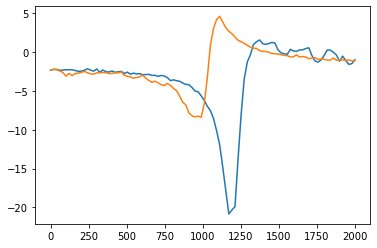

In [25]:
# horizontal cut
path = r'R03C-F7-C8\CoFeB\20230524'
fname = r'20230524-1244-11_fullB_stripe2_autosave_QAFM_b_field_fw.dat'

dat1 = np.loadtxt(os.path.join(pathbase,path,fname))
xax1 = np.linspace(0,2000,100)
yax1 = np.linspace(0,1000,10)

fitdat = -(21.22 - np.flipud(dat1[9,:]))

# vertical cut

# fname = r'20231206-0847-17_fullB_stripe1_autosave_QAFM_b_field_fw.dat'
path = r'R03C-F7-C8\CoFeB\20230524'
fname = r'20230524-1220-57_quench_1_autosave_QAFM_b_field_fw.dat'

dat2 = np.loadtxt(os.path.join(pathbase,path,fname))
yax2 = np.linspace(0,2000,100)
xax2 = np.linspace(0,1000,10)

fitdat2 = -(21.22 - np.flipud(dat2[:,9]))

plt.figure()
plt.plot(xax1,fitdat)
plt.plot(xax1,fitdat2)
plt.show()

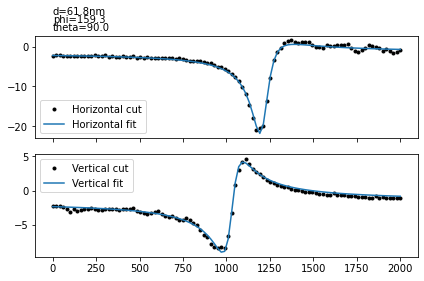

In [26]:
outm, dat = do_multifit(fitdat, fitdat2)

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(xax1,dat[:100],'k.',label='Horizontal cut')
ax[0].plot(xax1,outm.best_fit[:100],label='Horizontal fit')
ax[0].legend()
ax[1].plot(xax1,dat[100:],'k.',label='Vertical cut')
ax[1].plot(xax1,outm.best_fit[100:],label='Vertical fit')
ax[0].text(0,8,'d='+str(np.round(np.mean(dvals),1))+'nm')
ax[0].text(0,6,'phi='+str(np.round(np.mean(phivals),1)))
ax[0].text(0,4,'theta='+str(np.round(np.mean(thetavals),1)))
ax[1].legend()
fig.tight_layout()
plt.show()

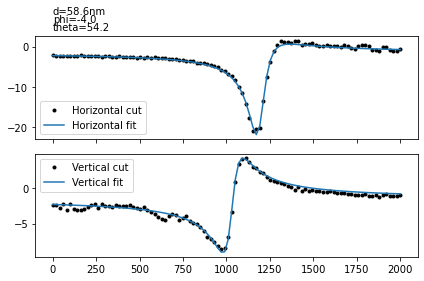

In [28]:
def do_multifit(fitdat, fitdat2):
    combinedat = np.concatenate([fitdat,fitdat2])

    mod = lm.Model(gen_Bslice_multi)
    pars = mod.make_params()
    pars['Is'].set(value=0.93*0.9e6,min=1e3,max=1e7,vary=True)
    pars['bias'].set(value=0.0,min=-5,max=5.,vary=True)
    pars['d'].set(value=100.,min=20.,max=300.,vary=True)
    pars['phi'].set(value=0.0,min=-200,max=200.,vary=True)
    pars['theta'].set(value=50.,min=0.0,max=90.0,vary=True)
    pars['x01'].set(value=1000,min=0.0,vary=True)
    pars['x02'].set(value=1000,min=0.0,vary=True)

    outm = mod.fit(combinedat,xax=xax1,params=pars)
    return outm, combinedat

# phi is defined with respect to the scan horizontal axis
dvals = []
thetavals = []
phivals = []

# loop through multiple slices and fit each independently
for k in range(9):
    fitdat = -(21.22 - np.flipud(dat1[k,:]))
    fitdat2 = -(21.22 - np.flipud(dat2[:,k]))
    outm, dat = do_multifit(fitdat, fitdat2)
    dvals.append(round(outm.params['d'].value,2))
    thetavals.append(round(outm.params['theta'].value,2))
    phivals.append(round(outm.params['phi'].value,2))


fitresults = {'d (nm)':dvals, 'theta':thetavals, 'phi':phivals}

fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(xax1,dat[:100],'k.',label='Horizontal cut')
ax[0].plot(xax1,outm.best_fit[:100],label='Horizontal fit')
ax[0].legend()
ax[1].plot(xax1,dat[100:],'k.',label='Vertical cut')
ax[1].plot(xax1,outm.best_fit[100:],label='Vertical fit')
ax[0].text(0,8,'d='+str(np.round(np.mean(dvals),1))+'nm')
ax[0].text(0,6,'phi='+str(np.round(np.mean(phivals),1)))
ax[0].text(0,4,'theta='+str(np.round(np.mean(thetavals),1)))
ax[1].legend()
fig.tight_layout()
plt.show()